In [2]:
import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt

In [3]:
NUM_DAYS = 30     # The number of days of historical data to retrieve
INTERVAL = '1d'     # Sample rate of historical data
symbol = 'SPY'      # Symbol of the desired stock

# List of symbols for technical indicators
INDICATORS = ['NIFTY']


[*********************100%***********************]  1 of 1 completed
                  open        high         low       close   Adj Close  \
Date                                                                     
2022-05-20  393.250000  397.029999  380.540009  389.630005  387.954163   
2022-05-23  392.829987  397.730011  390.380005  396.920013  395.212799   
2022-05-24  392.559998  395.149994  386.959991  393.890015  392.195831   
2022-05-25  392.309998  399.450012  391.890015  397.369995  395.660858   
2022-05-26  398.670013  407.040009  398.450012  405.309998  403.566711   

               volume  
Date                   
2022-05-20  131432200  
2022-05-23   76414900  
2022-05-24   91448800  
2022-05-25   91472900  
2022-05-26   82168300  


<AxesSubplot:xlabel='Date'>

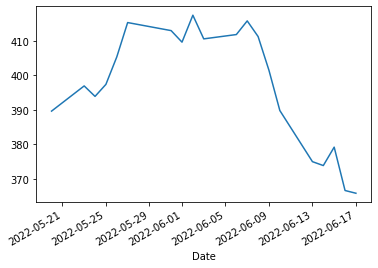

In [4]:
start = (datetime.date.today() - datetime.timedelta( NUM_DAYS ) )
end = datetime.datetime.today()

data = yf.download(symbol, start=start, end=end, interval=INTERVAL)
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
print(data.head())

tmp = data.iloc[-60:]
tmp['close'].plot()

<AxesSubplot:xlabel='Date'>

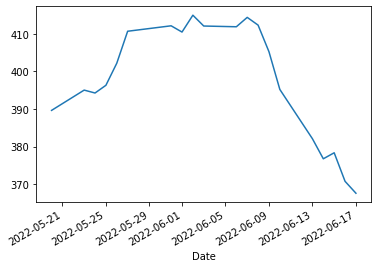

In [5]:
def _exponential_smooth(data, alpha):
    """
    Function that exponentially smooths dataset so values are less 'rigid'
    :param alpha: weight factor to weight recent values more
    """
    
    return data.ewm(alpha=alpha).mean()

data = _exponential_smooth(data, 0.65)

tmp1 = data.iloc[-60:]
tmp1['close'].plot()

In [6]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for indicator in INDICATORS:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # Also calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()

    # Remove columns that won't be used as features
    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    
    return data
print(data.columns)

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume'], dtype='object')


In [7]:
live_pred_data = data.iloc[-16:-11]

In [8]:
def _produce_prediction(data, window):
    """
    Function that produces the 'truth' values
    At a given row, it looks 'window' rows ahead to see if the price increased (1) or decreased (0)
    :param window: number of days, or rows to look ahead to see what the price did
    """
    
    prediction = (data.shift(-window)['close'] >= data['close'])
    prediction = prediction.iloc[:-window]
    data['pred'] = prediction.astype(int)
    
    return data

data = _produce_prediction(data, window=15)
del (data['close'])
data = data.dropna() # Some indicators produce NaN values for the first few rows, we just remove them here
data.tail()

,open,high,low,Adj Close,volume,pred
Date,,,,,,
2022-05-20,393.250000,397.029999,380.540009,387.954163,1.314322e+08,0.0
2022-05-23,392.938879,397.548526,387.828895,393.330930,9.067864e+07,0.0
2022-05-24,392.681574,395.919642,387.238808,392.560065,9.120167e+07,0.0
2022-05-25,392.436370,398.249343,390.308152,394.606287,9.138066e+07,0.0
2022-05-26,396.509632,403.993445,395.628303,400.461314,8.536101e+07,0.0
